In [1]:
#pip install tensorflow pandas numpy matplotlib yahoo_fin sklearn

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install yahoo_fin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [114]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#import yfinance as si
from yahoo_fin.stock_info import get_data as si
#from yahoo_fin.stock_info import get_data as si
#from yahoo_fin import stock_info as si
from collections import deque

import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
#import plotly.graph_objs as go
import plotly.graph_objects as go
cf.go_offline()
cf.set_config_file(offline = True)
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

In [115]:
# Specify the ticker symbol for Yahoo Finance Data (ADBE)
ticker = ['ADBE']

In [116]:
df = yf.download(ticker,start = '2010-01-01', end='2022-12-31').dropna()

[*********************100%***********************]  1 of 1 completed


### EXPLORATORY DATA ANALYSIS

In [117]:
# Check if there is any missing values
df.isnull().values.any()

False

In [118]:
# Analysing the statistic summary of the dataframe
df.describe()

Open         High  ...    Adj Close        Volume
count  3272.000000  3272.000000  ...  3272.000000  3.272000e+03
mean    186.068857   188.254349  ...   186.068298  3.813703e+06
std     173.554604   175.666975  ...   173.459523  3.597777e+06
min      22.969999    23.360001  ...    22.690001  5.892000e+05
25%      42.772499    43.409999  ...    42.910000  2.122025e+06
50%      97.664997    98.309998  ...    97.755001  2.948050e+06
75%     289.360008   292.534996  ...   287.970001  4.363275e+06
max     696.280029   699.539978  ...   688.369995  1.087524e+08

[8 rows x 6 columns]

In [119]:
df.head(5)

Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2010-01-04  36.650002  37.299999  36.650002  37.090000  37.090000  4710200
2010-01-05  37.040001  37.799999  36.869999  37.700001  37.700001  7108800
2010-01-06  37.330002  37.740002  37.200001  37.619999  37.619999  5336400
2010-01-07  37.410000  37.590000  36.810001  36.889999  36.889999  5576700
2010-01-08  36.750000  36.970001  36.340000  36.689999  36.689999  5429200

The data contains open price, high price, low price, close price, adj close price, and volume for the stock. The following table shows the Adobe stock price data from beginning of 2010.

In [120]:
# we first select the 'Adj Close' column from a DataFrame df using the syntax df['Adj Close']. 
# This returns a Pandas Series object containing the adjusted closing prices for a particular security (represented by the ticker symbol ADBE).
df_adj_close = df['Adj Close']
df_adj_close = df_adj_close.to_frame()
df_adj_close.columns = [ticker[0]]
df_adj_close.head()

ADBE
Date                 
2010-01-04  37.090000
2010-01-05  37.700001
2010-01-06  37.619999
2010-01-07  36.889999
2010-01-08  36.689999

In [121]:
# Displaying the change in price between 2010 - 2022 to have a rough idea 
df_adj_close.iplot(title = 'Price Change between 2010 and 2022')

 Stock shows upward trend based on years till 2021 but there is drastic drop in 2022 but a fluctuation can be 
 observed after the mid of 2022 


In [122]:
# Calculating daily return change using the built in function
ret = df_adj_close.pct_change()
ret.iplot(colors = 'Blue',title = 'Daily Return Between 2010 and 2021')

In [123]:
#This function will help in calculating annual risk and return for stocks
def ann_risk_return(returns_df):
    summary = returns_df.agg(["mean", "std"]).T
    summary.columns = ["Return", "Risk"]
    summary.Return = summary.Return*252
    summary.Risk = summary.Risk * np.sqrt(252)
    return summary
summary = ann_risk_return(ret)
summary

Return      Risk
ADBE  0.220433  0.317046

We also calculate aggregated annual return and risk and the result indicates that annual return is 28% and risk is 30%

In [124]:
stocks_monthly_price = df_adj_close.resample('M',kind='period').last()
ret_month = stocks_monthly_price.pct_change().dropna()
month_cum_ret = (1+ret_month).cumprod()
month_cum_ret.iplot(color = 'Red')

### Moving Average Comparison for 50,100,200 days
##### Simple Moving Average(SMA) is a stock indicator that is commonly used in finance as technical indicator. The reason for calculating SMA is to get smooth out the stock price data

In [125]:
def cal_sma50_sma100_sma200(df):
    stocks_SMA= pd.DataFrame()
    for stock in df.columns:
        stocks_SMA['{}'.format(stock)] = df[stock]
        stocks_SMA["{} SMA50".format(stock)]=df[stock].rolling(window = 50).mean()
        stocks_SMA["{} SMA100".format(stock)]=df[stock].rolling(window = 100).mean()
        stocks_SMA["{} SMA200".format(stock)]=df[stock].rolling(window = 200).mean()
    return stocks_SMA

cal_sma50_sma100_sma200(df_adj_close)

ADBE  ADBE SMA50  ADBE SMA100  ADBE SMA200
Date                                                        
2010-01-04   37.090000         NaN          NaN          NaN
2010-01-05   37.700001         NaN          NaN          NaN
2010-01-06   37.619999         NaN          NaN          NaN
2010-01-07   36.889999         NaN          NaN          NaN
2010-01-08   36.689999         NaN          NaN          NaN
...                ...         ...          ...          ...
2022-12-23  338.450012  323.907799   340.365299   374.445150
2022-12-27  335.089996  324.850799   339.410299   374.038699
2022-12-28  328.329987  325.547399   338.359299   373.622849
2022-12-29  337.579987  326.439398   337.391699   373.202449
2022-12-30  336.529999  327.173398   336.491299   372.673299

[3272 rows x 4 columns]

In [126]:
cal_sma50_sma100_sma200(df_adj_close)

ADBE  ADBE SMA50  ADBE SMA100  ADBE SMA200
Date                                                        
2010-01-04   37.090000         NaN          NaN          NaN
2010-01-05   37.700001         NaN          NaN          NaN
2010-01-06   37.619999         NaN          NaN          NaN
2010-01-07   36.889999         NaN          NaN          NaN
2010-01-08   36.689999         NaN          NaN          NaN
...                ...         ...          ...          ...
2022-12-23  338.450012  323.907799   340.365299   374.445150
2022-12-27  335.089996  324.850799   339.410299   374.038699
2022-12-28  328.329987  325.547399   338.359299   373.622849
2022-12-29  337.579987  326.439398   337.391699   373.202449
2022-12-30  336.529999  327.173398   336.491299   372.673299

[3272 rows x 4 columns]

### Based on the moving average chart, the stock indicate a buy signal since 50 days moving average crosses the 100 days moving average(SMA) though it did not crosses the 200 days moving average(SMA) 

In [127]:
moving_avg = cal_sma50_sma100_sma200(df_adj_close)
moving_avg.iplot(title = 'Comparison the moving averages')

## Annual Return Triangle

In [128]:
## In this part of the data analysis, we take a look at the historical annual return on the stock.
## then we calculated the annual return

## The annual return triangle shows the historical annual returns on 12 years period

annual = df_adj_close.resample("A", kind = "period").last()
annual

ADBE
Date            
2010   30.780001
2011   28.270000
2012   37.680000
2013   59.880001
2014   72.699997
2015   93.940002
2016  102.949997
2017  175.240005
2018  226.240005
2019  329.809998
2020  500.119995
2021  567.059998
2022  336.529999

In [129]:
annual_log_ret = np.log(annual/annual.shift())
annual_log_ret.dropna(inplace = True)
years = annual_log_ret.index.size

def annual_return_triangle(df,annual_log_ret):
    windows = [year for year in range(years, 0, -1)]
    for i in df.columns:
        for year in windows:
            annual_log_ret["{}{}Y".format(i,year)] = annual_log_ret[i].rolling(year).mean()
    return annual_log_ret

an_ret_tri = annual_return_triangle(df_adj_close,annual_log_ret)

triangle= an_ret_tri.drop(columns = df_adj_close.columns)
print(triangle.columns)
print(triangle)

Index(['ADBE12Y', 'ADBE11Y', 'ADBE10Y', 'ADBE9Y', 'ADBE8Y', 'ADBE7Y', 'ADBE6Y',
       'ADBE5Y', 'ADBE4Y', 'ADBE3Y', 'ADBE2Y', 'ADBE1Y'],
      dtype='object')
       ADBE12Y   ADBE11Y   ADBE10Y  ...    ADBE3Y    ADBE2Y    ADBE1Y
Date                                ...                              
2011       NaN       NaN       NaN  ...       NaN       NaN -0.085064
2012       NaN       NaN       NaN  ...       NaN  0.101132  0.287328
2013       NaN       NaN       NaN  ...  0.221826  0.375271  0.463213
2014       NaN       NaN       NaN  ...  0.314847  0.328606  0.193999
2015       NaN       NaN       NaN  ...  0.304509  0.225157  0.256315
2016       NaN       NaN       NaN  ...  0.180634  0.173951  0.091587
2017       NaN       NaN       NaN  ...  0.293272  0.311750  0.531913
2018       NaN       NaN       NaN  ...  0.292980  0.393677  0.255440
2019       NaN       NaN       NaN  ...  0.388091  0.316180  0.376920
2020       NaN       NaN  0.278798  ...  0.349564  0.396626  0.416331


In [130]:
def graph_annual_return_triangle(df):
    i=0
    new_list=[]
    while i<len(triangle.columns.values):
        new_list.append(df.columns.values[i:i+years])
        i+=years
    for i in new_list:
        plt.figure(figsize=(30,20))
        sns.set(font_scale=2)
        sns.heatmap(df[i], annot = True, fmt = ".1%", cmap = "RdYlGn")
        plt.tick_params(axis = "y", labelright =True)
    return plt.show()

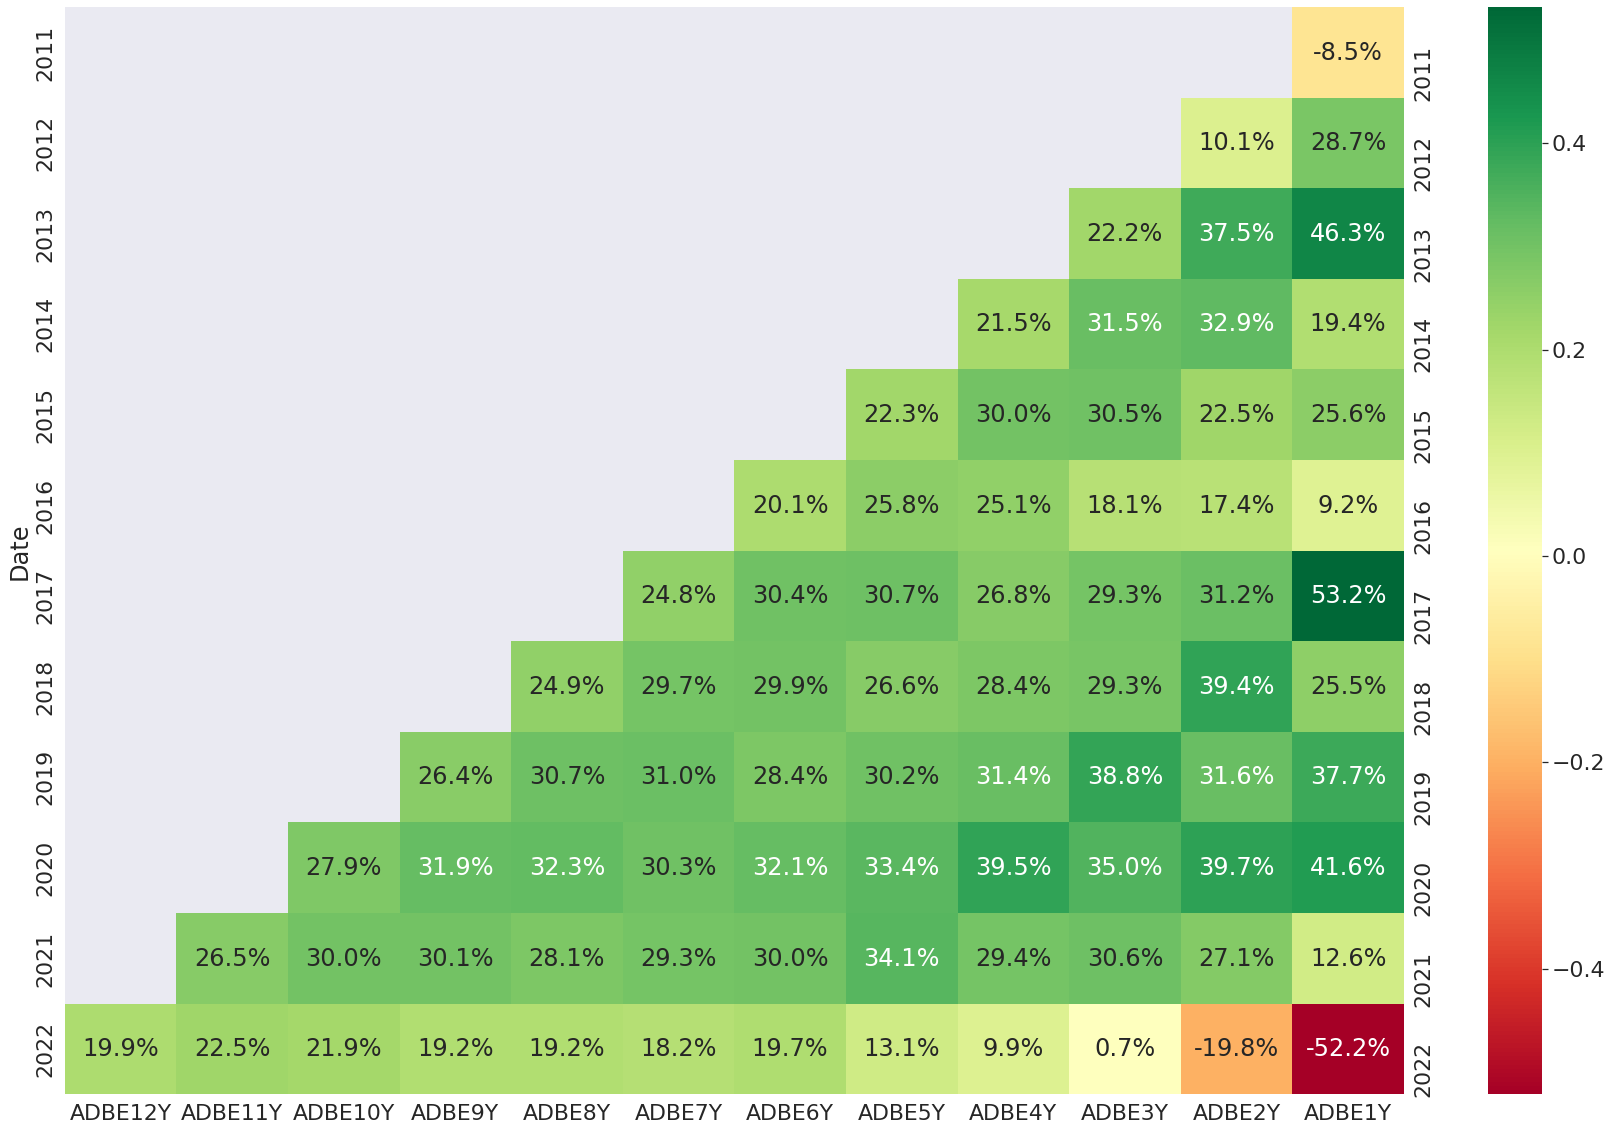

In [131]:
graph_annual_return_triangle(triangle)

The following codes show how to build the annual triangle return graph. When i look at the graph, i can see that in 12 years period, the stock is gained a different percentage of return. For example, ADBE1Y and 2021 intersection show us one-year annual return is 9.2%. if someone buys the stock in 2020 and holds it for one year, he would get 41.6% (2020 and ADBE1Y intersection) while he would loss -8.5% if the stock was bought in 2011 for one-year period.

## Data Preparation

In [132]:
# First thing we  normalize the data with sklearn's MinMaxScaler function. We created a function for it.
# The data will be scaled between 0 - 1

def normalize_featuresDF(df):
    """
    We created to normalize df data - range between 0-1
    args:
        df : the data we pulled up from yahoo for the stock
    return:
        normalized_features_df : data after it is normalized
    
    """
    scaler = MinMaxScaler()
    feature_columns = df.columns
    feature_minmax_data = scaler.fit_transform(df)
    normalized_features_df = pd.DataFrame(columns=feature_columns, data=feature_minmax_data, index=df.index)
    
    
    return normalized_features_df

##  Split the data into Train, Test and Validation sets

In [133]:
def split_ValidationSet(features_df, target_df, length=90):
    """
    method is to separate validation set from the complete df
    args:
        features_df: full features_df
        target_df :  full target_df
        length: prediction length
    returns : 
        validation_x : returns features validations sets
        validation_y : returns target validations sets
    """
    #need to shift target array because we are prediction n + 1 days price
    target_df = target_df.shift(-1)
    #split validation set . i am spliting 10% latest data for validation.
    #target
    validation_y = target_df[-length:-1]
    validation_x = features_df[-length:-1]
    
    return validation_x, validation_y

#Now get final_features_df and final_target_df by excluding validation set
def split_Final_df(normalized_features_df, target_df, v_length=90):
    """
    This method will be having remaining data after the validation set.
    args:
        features_df: normalized features_df
        target_df: complete target_df
        v_length: validation set length
    return: 
        final_features_df : set of feature df excluding validation set
        final_target_df : set of target df excluding validation set
    """
    final_features_df = normalized_features_df[:-v_length]
    final_target_df = target_df[:-v_length]
    
    return final_features_df, final_target_df

The train set is the sample of data used to fit the model. 
The validation set is used to provide an unbiased evaluation of a model fit on a training set while tuning model hyperparameters.
The test set is used for the final evaluation after the model is completely trained with the train and validation set.

## Train and Test split - Timeseries split

In [134]:
#Split final set into training and testing sets
#splitting training and testing set using sklearn's TimeSeries split
def split_Train_Test_DF(final_features_df, final_target_df, n_splits=10):
    """
    Using sklearn's timeseries split to split the training and testing sets
    args:
        final_features_df: features_df after splitting validation set
        final_target_df: target_df after splitting validation set
    
    return: 
        x_train : traing feature set
        y_train : training target set
        x_test : testing feature set
        y_test : testing target set
    """
    ts_split = TimeSeriesSplit(n_splits)
    for train_index, test_index in ts_split.split(final_features_df):
        x_train, x_test = final_features_df[:len(train_index)], final_features_df[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = final_target_df[:len(train_index)].values.ravel(), final_target_df[len(train_index): (len(train_index)+len(test_index))].values.ravel()
        
    return x_train, y_train, x_test, y_test

### Visualizing the datasets using graph

In [135]:
def DataSet_Graph():
    """
    
    Chart shows 2 different sets(Train,Test,Validation) into single plot
    Since it is time series data, it shouldnot be mixed 
    """
    t=y_test.astype(np.float)
    v = target_df[-90:-1].values.ravel()
    plt.figure(figsize = (20,10))
    plt.plot(y_train, label='trainning_set')
    plt.plot([None]*len(y_train) + [x for x in t], label='test_set')
    plt.plot([None]*(len(y_train)+len(t)) + [x for x in v], label='validation_set')
    plt.xlabel('Days',fontsize = 18)
    plt.ylabel('Price',fontsize = 18)
    plt.title('Split dataset into training/validation/test set',fontsize = 20)
    plt.legend()

## Implementing model prediction and evaluation

In [136]:
#Method to evaluate the benchmark model and solution model with validate data set
def model_validateResult(model, model_name):
    """
    Returns RMSE_Score and R2_Score
    Also plots actual vs predicted trend
    args:
        model : the model is to validate
        model_name: name of the model
    return:
        RMSE_Score : calculates rmse score
        R2_Score : calculates R2 score
    """

    model = model(x_train, y_train, validation_x)
    prediction = model.predict(validation_x)
    RMSE_Score = np.sqrt(mean_squared_error(validation_y, prediction))
    R2_Score = r2_score(validation_y, prediction)
    
    #trendline for actual vs prediction

    plt.figure(figsize = (23,10))
    plt.plot(validation_y.index, prediction, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='green', markersize=8,label = 'Prediction data')
    plt.plot(validation_y.index, validation_y, color='red', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='red', markersize=8,label = 'Actual data')
    plt.plot(figsize = (23,10))
    plt.ylabel('Price',fontsize = 20)
    plt.xlabel('Date',fontsize = 20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual',fontsize = 20)
    plt.legend(loc='upper left')
    plt.show()
    print(model_name + ' RMSE: ', RMSE_Score)
    print(model_name + ' R2 score: ', R2_Score)
    return RMSE_Score, R2_Score




#Method to evaluate the final model with testing data set
def bestModel_validateResult(model, model_name):
    """
    Returns RMSE_Score and R2_Score
    Also plots actual vs predicted trend
    args:
        model : the model is to validate
        model_name: name of the model
    return:
        RMSE_Score : calculates rmse score
        R2_Score : calculates R2 score
    """ 
    #I am giving testing set for the evaluation 
    model = model(x_train, y_train, x_test)
    prediction = model.predict(x_test)
    
    RMSE_Score = np.sqrt(mean_squared_error(y_test, prediction))
    R2_Score = r2_score(y_test, prediction)
    plt.figure(figsize = (23,10))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(model_name + 'Prediction Vs Actual',fontsize = 20)
    plt.plot(y_test, label='test data')
    plt.plot(prediction, label='prediction')
    plt.xlabel('Days',fontsize = 20)
    plt.ylabel('Price',fontsize = 20)
    plt.legend();
    print(model_name + ' RMSE: ', RMSE_Score)
    print(model_name + ' R2 score: ', R2_Score) 
    return RMSE_Score, R2_Score



def value_Compare(model):
    """
    this method is used to create final data frame using testing value with predicted value.
    args:
        model : trained model
    return : 
        df : df with test value and predicted value
    """
    model = model(x_train, y_train, x_test)
    prediction = model.predict(x_test)
    col1 = pd.DataFrame(y_test, columns=['True_value'])
    col2 = pd.DataFrame(prediction, columns = ['Predicted_value'])
    df = pd.concat([col1, col2], axis=1)
    return df

We focused on error between the actual and predicted value . For that reason we use RMSE(Root Mean Square Error ) and R-Squared(R2) metrics. Both metrics works well to select the best model to predict stock prices. Both metrics measure the errors as well as they serve as loss functions to minimize.

We have created three different functions. First one is model_validateResult(). It uses the validation data set then return RMSE score and R2 Score. It also builds and returns graph to show trendline for actual vs prediction data. The second function is bestModel_validateResult(). It uses test dataset then returns RMSE score and R2 score with graph building trendline for actual prediction test data. The last function is value_Compare(). It generates dataset to show difference between actual data and predicted data.

## Build Models with functions

### 1. Decision Tree

In [137]:
#modeling DecisionTreeRegressor with default parameters

def model_Decision_Tree_Regressor(x_train, y_train,validation_x, random_state=0):
    """
    Method is to model DecisionTreeRegressor
    args:
        x_train : feature training set
        y_train : target training set
        validation_x : validation feature set
        random_state : default parameter it controls the randomness of the estimater
    
    return: 
        model : returns the trained model
        
    """
    #initialize DTR
    dtr = DecisionTreeRegressor(random_state=0)   
    #fit the data
    model = dtr.fit(x_train, y_train)
    
    return model

### 2. Support Vector Machine

In [138]:
def model_SVR(x_train, y_train, validation_x):
    
    """
    This method uses svr algorithm to trian the data.
    args:
        x_train : feature training set
        y_train : target training set
        validation_x : validation feature set
    return:
        model : returns the trained model
    """
    svr_model = SVR(kernel='linear')
    model = svr_model.fit(x_train, y_train)
    return model

def model_SVRTuning(x_train, y_train, validation_x):
    """
    This method uses svr algorithm to trian the data.
    Using different set of C and epsilon.
    Using GridSearchCV to select best hyperparameters
    args:
        x_train : feature training set
        y_train : target training set
        validation_x : validation feature set
    return:
        model : returns the trained model
    """
    hyperparameters_linearSVR = {
        'C':[0.5, 1.0, 10.0, 50.0, 100.0, 120.0,150.0, 300.0, 500.0,700.0,800.0, 1000.0],
        'epsilon':[0, 0.1, 0.5, 0.7, 0.9],
    }
    
    grid_search_SVR_feat = GridSearchCV(estimator=model_SVR(x_train, y_train, validation_x),
                           param_grid=hyperparameters_linearSVR,
                           cv=TimeSeriesSplit(n_splits=10),
    )

    model = grid_search_SVR_feat.fit(x_train, y_train)
    #print(grid_search_SVR_feat.best_params_)
    
    return model

### Stochastic Gradient Descent

In [139]:
def Stochastic_Gradient_Descent_model(x_train,y_train,validation_x):

    sgd =SGDRegressor(max_iter=1000, tol=1e-3,loss='squared_epsilon_insensitive',penalty='l1',alpha=0.1)
    model = sgd.fit(x_train,y_train)
#     prediction = model.predict(validation_x)
    return model

##  Implimentation
#### Selecting features df and target df
#### Normalizing the data

In [140]:
#normalizing features df
normalized_features_df = normalize_featuresDF(df)
target_df = df[['Adj Close']]

In [141]:
#Get shape of the features and target data
print("feature_df has (rows, columns) : {} ".format(normalized_features_df.shape))
print("target_df has (rows, columns) : {} ".format(target_df.shape))

feature_df has (rows, columns) : (3272, 6) 
target_df has (rows, columns) : (3272, 1) 


In [142]:
print(normalized_features_df)
print(target_df)

                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2010-01-04  0.020318  0.020616  0.021303  0.021632   0.021632  0.038100
2010-01-05  0.020897  0.021355  0.021638  0.022548   0.022548  0.060276
2010-01-06  0.021327  0.021267  0.022141  0.022428   0.022428  0.043889
2010-01-07  0.021446  0.021045  0.021547  0.021332   0.021332  0.046111
2010-01-08  0.020466  0.020128  0.020831  0.021031   0.021031  0.044747
...              ...       ...       ...       ...        ...       ...
2022-12-23  0.463427  0.466681  0.473333  0.474342   0.474342  0.009621
2022-12-27  0.467883  0.465557  0.472068  0.469295   0.469295  0.008091
2022-12-28  0.463516  0.466059  0.464038  0.459140   0.459140  0.010012
2022-12-29  0.457115  0.467538  0.467954  0.473035   0.473035  0.011130
2022-12-30  0.460457  0.463309  0.470819  0.471458   0.471458  0.010642

[3272 rows x 6 columns]
             Adj Close
Date            

### Splitting train, test and validation sets

In [143]:
#Splitting validation sets from the final features and target df
validation_x, validation_y = split_ValidationSet(normalized_features_df, target_df)

In [144]:
print("validation_x has (rows, columns) : {} ".format(validation_x.shape))
print("validation_y has (rows, columns) : {} ".format(validation_y.shape))

validation_x has (rows, columns) : (89, 6) 
validation_y has (rows, columns) : (89, 1) 


In [145]:
#splitting train and test set from validation set
final_features_df, final_target_df = split_Final_df(normalized_features_df, target_df)

In [146]:
print("final_features_df has (rows, columns) : {} ".format(final_features_df.shape))
print("final_target_df has (rows, columns) : {} ".format(final_target_df.shape))

final_features_df has (rows, columns) : (3182, 6) 
final_target_df has (rows, columns) : (3182, 1) 


### Splitting Train and Test using Skleans TimeSeriesSplit

In [147]:
#splitting train and test
x_train, y_train, x_test, y_test = split_Train_Test_DF(final_features_df, final_target_df)

In [148]:
print("Shape of training sets x_train : {}, y_train : {}".format(x_train.shape, y_train.shape))
print("Shape of testing sets x_train : {}, y_train : {}".format(x_test.shape, y_test.shape))

Shape of training sets x_train : (2893, 6), y_train : (2893,)
Shape of testing sets x_train : (289, 6), y_train : (289,)


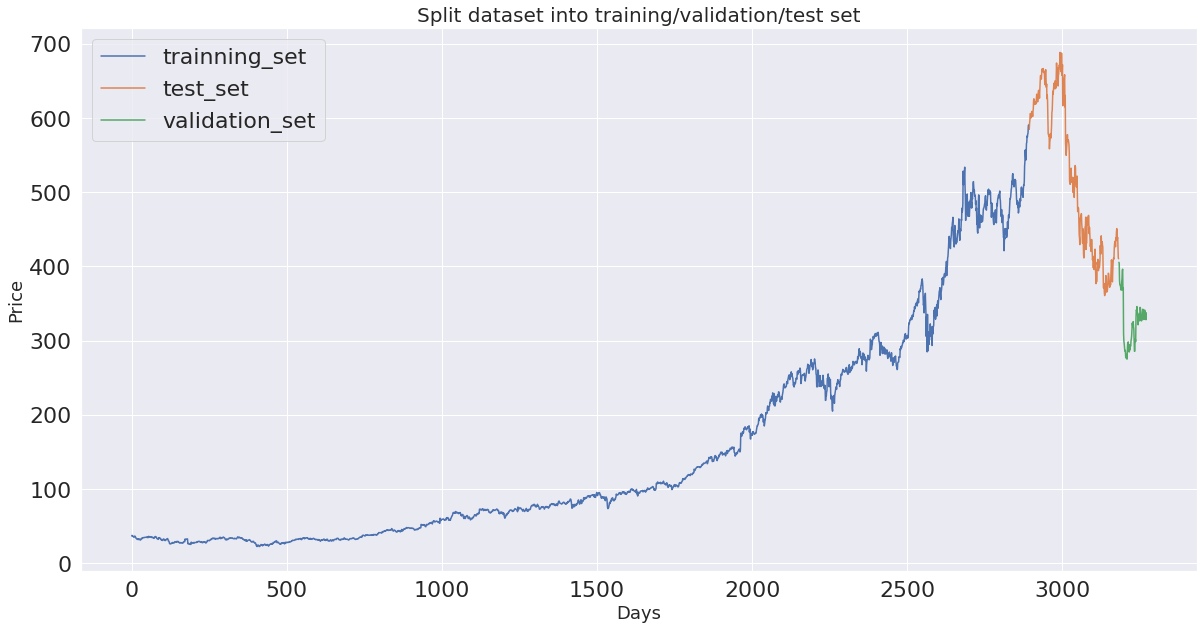

In [149]:
#Visualizing the train, test and validation sets in single plot
#Starbucks
DataSet_Graph()

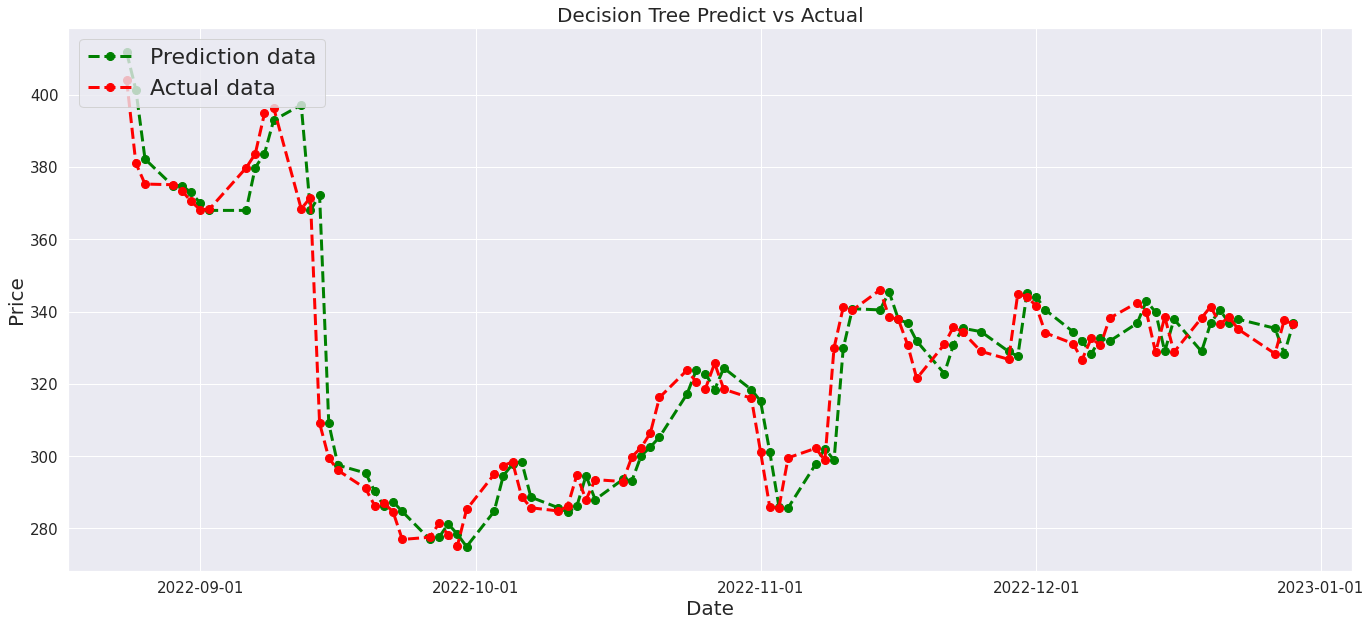

Decision Tree RMSE:  10.51448914569442
Decision Tree R2 score:  0.8881708660573423


In [150]:
# Getting the RMSE and R2 score by predicting the model.
# DTR model RMSE and R2 score with plot
RMSE_Score, R2_Score = model_validateResult(model_Decision_Tree_Regressor, model_name = "Decision Tree")

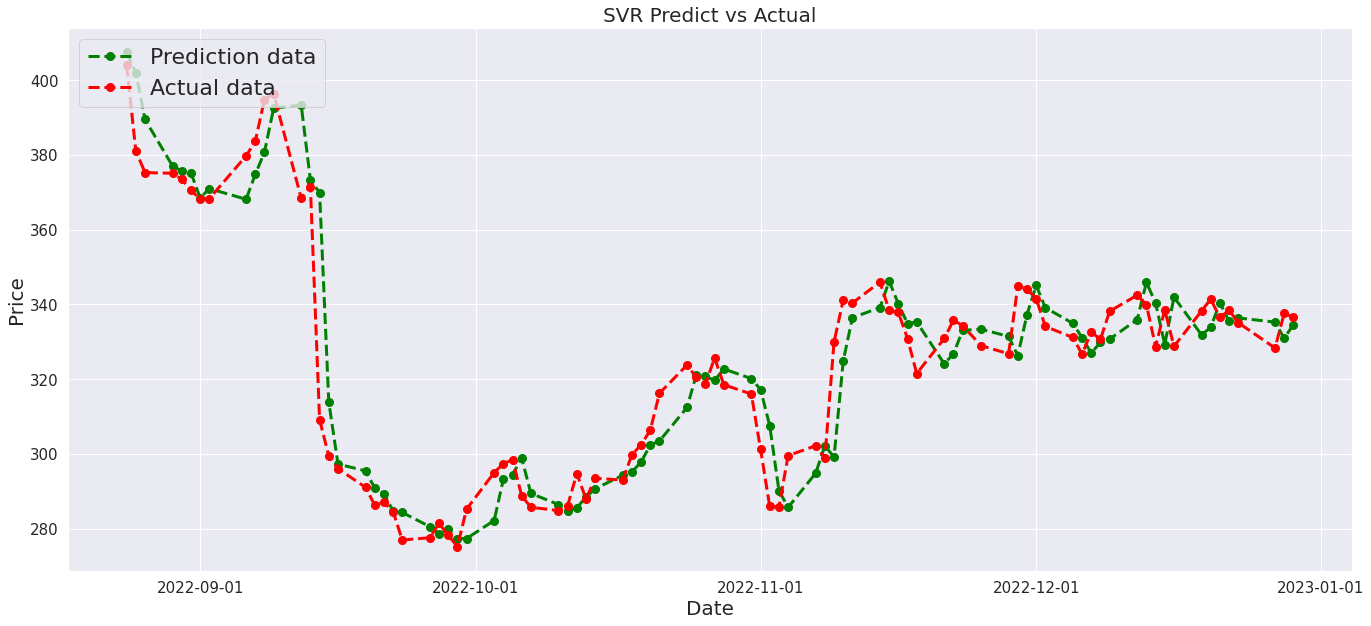

SVR RMSE:  10.928903675997454
SVR R2 score:  0.8791819549975133


In [151]:
#SVR model
RMSE_Score, R2_Score = model_validateResult(model_SVR, model_name = "SVR")

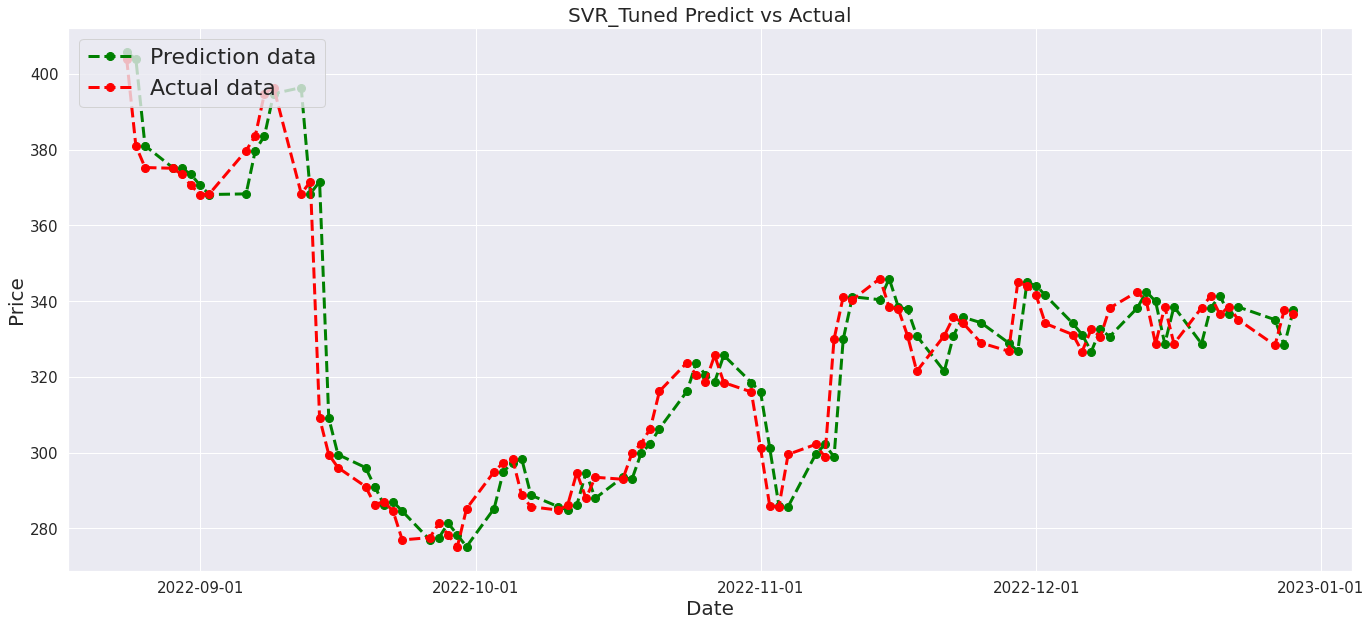

SVR_Tuned RMSE:  10.517043329774054
SVR_Tuned R2 score:  0.8881165282987421


In [152]:
#SVR model Tuning
RMSE_Score, R2_Score = model_validateResult(model_SVRTuning, model_name = "SVR_Tuned")

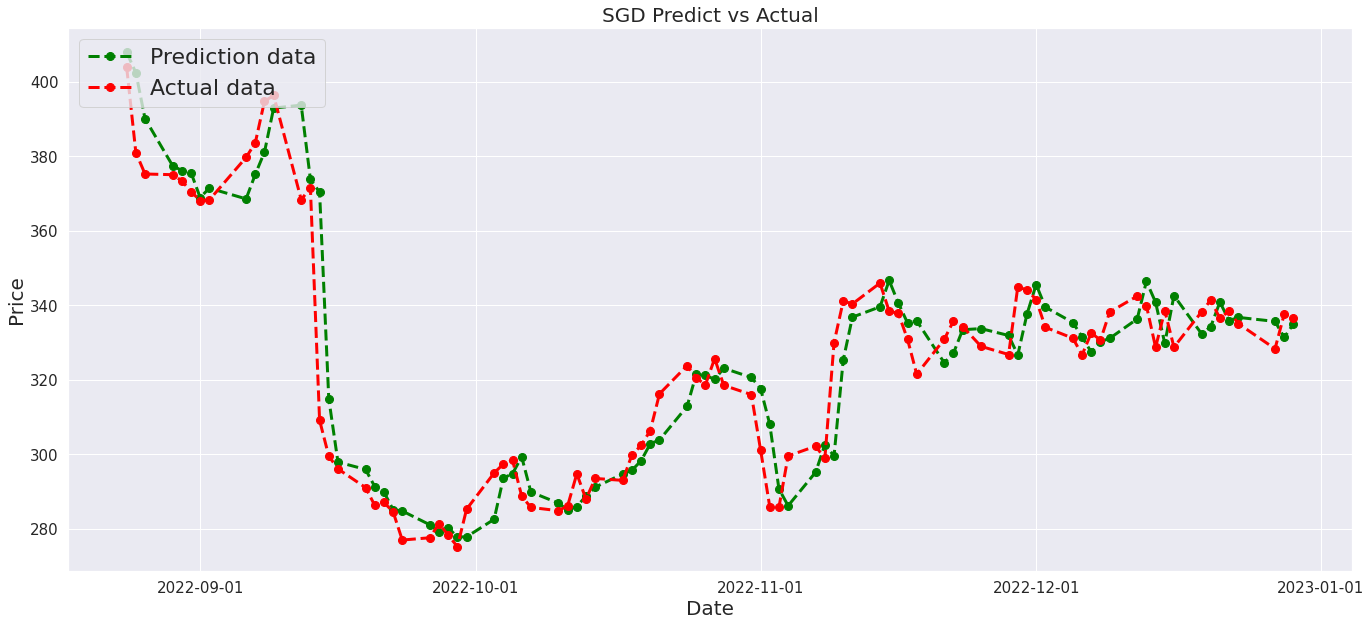

SGD RMSE:  10.987482143943716
SGD R2 score:  0.8778833246316988


In [153]:
#Stochastic_Gradient_Descent_model
RMSE_Score, R2_Score = model_validateResult(Stochastic_Gradient_Descent_model, model_name = "SGD")


### Implementation of CNN (LSTM Model)

In [154]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):

    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        #df = si.get_data(ticker)
        df = si(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [155]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

### Trainig the LSTM model

In [156]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 15
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 1
# Amazon stock market
ticker = "AMZN"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [157]:
# set seed, so we can get the same results after rerunning several times
import random 
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [158]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [159]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        # df = si.get_data(ticker)
        df = si(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [160]:
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

81/81 [==============================] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0300
Epoch 1: val_loss improved from inf to 0.00052, saving model to results/2023-02-25_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
81/81 [==============================] - 57s 653ms/step - loss: 0.0027 - mean_absolute_error: 0.0300 - val_loss: 5.2151e-04 - val_mean_absolute_error: 0.0157


In [161]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [162]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [163]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [164]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [165]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [166]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

41/41 [==============================] - 4s 83ms/step


In [167]:
# predict the future price
future_price = predict(model, data)

1/1 [==============================] - 0s 31ms/step


In [168]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [169]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 15 days is 92.77$
huber_loss loss: 0.0005215088021941483
Mean Absolute Error: 2.9889644078490982
Accuracy score: 0.4311284046692607
Total buy profit: 35.5040407180786
Total sell profit: -200.0787182897329
Total profit: -164.57467757165432
Profit per trade: -0.12807367904408898


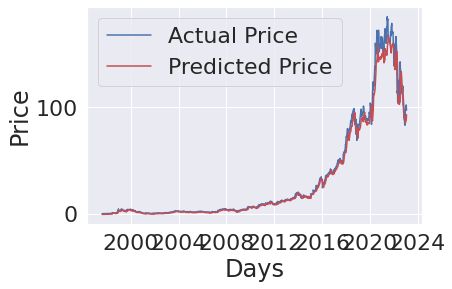

In [170]:
# plot true/pred prices graph
plot_graph(final_df)

In [171]:
print(final_df.tail(10))
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)

                 open        high  ...  buy_profit  sell_profit
2022-11-14  98.769997  100.120003  ...         0.0    10.239998
2022-11-25  93.790001   94.430000  ...         0.0     5.550003
2022-11-29  94.040001   94.410004  ...         0.0     7.229996
2022-11-30  92.470001   96.540001  ...         0.0     9.770004
2022-12-05  93.050003   94.059998  ...         0.0     7.970001
2022-12-13  95.230003   96.250000  ...         0.0     9.369995
2022-12-15  89.889999   89.970001  ...         0.0     1.089996
2022-12-21  86.180000   87.230003  ...         0.0   -11.350006
2023-01-17  98.680000   98.889999  ...         0.0    -6.059998
2023-01-27  99.529999  103.489998  ...         0.0     5.040001

[10 rows x 11 columns]


In [180]:
df['YEAR']  = df.index.strftime("%Y")     # YEAR
df['MONTH'] = df.index.strftime("%Y-%m")  # YEAR-MONTH
df['WEEK']  = df.index.strftime("%Y-%U")  # YEAR-WEEK


#  create time dataframes using GROUPBY
df_yr = df.groupby('YEAR').sum()
df_mh = df.groupby('MONTH').sum()
df_wk = df.groupby('WEEK').sum()


#  print index and column names
print("\nperf_dy:\n", df.index.name, df.columns.values)
print("\nperf_yr:\n", df.index.name, df.columns.values)
print("\nperf_mh:\n", df.index.name, df.columns.values)
print("\nperf_wk:\n", df.index.name, df.columns.values)


perf_dy:
 Date ['Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume' 'YEAR' 'MONTH' 'WEEK']

perf_yr:
 Date ['Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume' 'YEAR' 'MONTH' 'WEEK']

perf_mh:
 Date ['Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume' 'YEAR' 'MONTH' 'WEEK']

perf_wk:
 Date ['Open' 'High' 'Low' 'Close' 'Adj Close' 'Volume' 'YEAR' 'MONTH' 'WEEK']


In [181]:
df

Open        High         Low  ...  YEAR    MONTH     WEEK
Date                                            ...                        
2010-01-04   36.650002   37.299999   36.650002  ...  2010  2010-01  2010-01
2010-01-05   37.040001   37.799999   36.869999  ...  2010  2010-01  2010-01
2010-01-06   37.330002   37.740002   37.200001  ...  2010  2010-01  2010-01
2010-01-07   37.410000   37.590000   36.810001  ...  2010  2010-01  2010-01
2010-01-08   36.750000   36.970001   36.340000  ...  2010  2010-01  2010-01
...                ...         ...         ...  ...   ...      ...      ...
2022-12-23  335.000000  338.920013  333.290009  ...  2022  2022-12  2022-51
2022-12-27  338.000000  338.160004  332.459991  ...  2022  2022-12  2022-52
2022-12-28  335.059998  338.500000  327.190002  ...  2022  2022-12  2022-52
2022-12-29  330.750000  339.500000  329.760010  ...  2022  2022-12  2022-52
2022-12-30  333.000000  336.640015  331.640015  ...  2022  2022-12  2022-52

[3272 rows x 9 columns]

In [182]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'YEAR', 'MONTH',
       'WEEK'],
      dtype='object')

<Figure size 720x576 with 0 Axes>

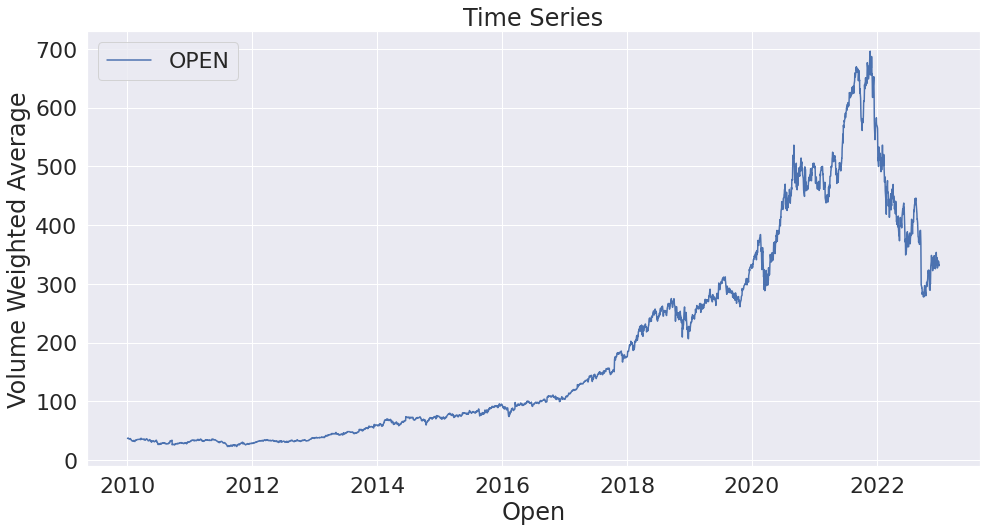

In [191]:
plt.figure(figsize=(10,8))

#  subplot #1
plt.figure(figsize=(16,8)) 
plt.plot(df['Open'], label='OPEN') 
plt.title('Time Series') 
plt.xlabel("Open") 
plt.ylabel("Volume Weighted Average") 
plt.legend(loc='best')
      
plt.show()  # plot subplots


<Figure size 720x576 with 0 Axes>

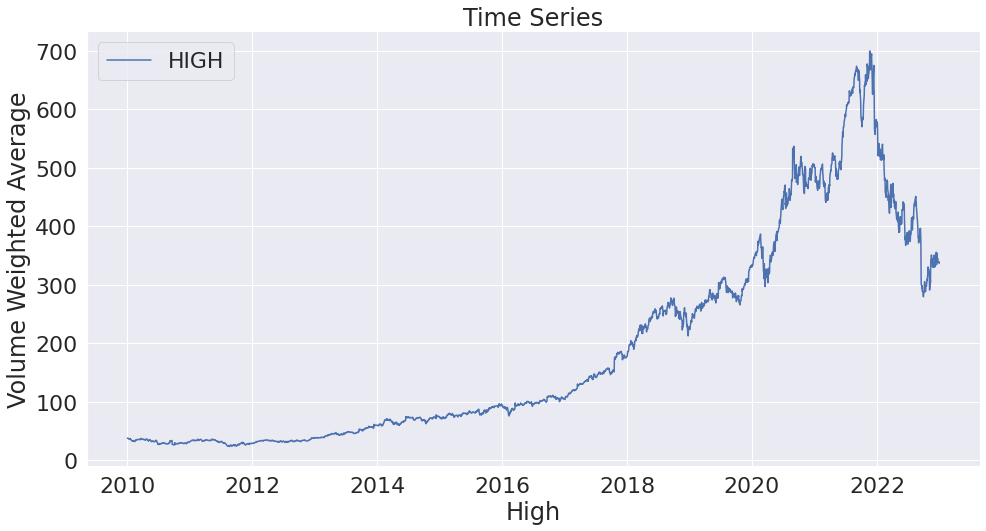

In [192]:
plt.figure(figsize=(10,8))

#  subplot #2
plt.figure(figsize=(16,8)) 
plt.plot(df['High'], label='HIGH') 
plt.title('Time Series') 
plt.xlabel("High") 
plt.ylabel("Volume Weighted Average") 
plt.legend(loc='best')
      
plt.show()  # plot subplots


<Figure size 720x576 with 0 Axes>

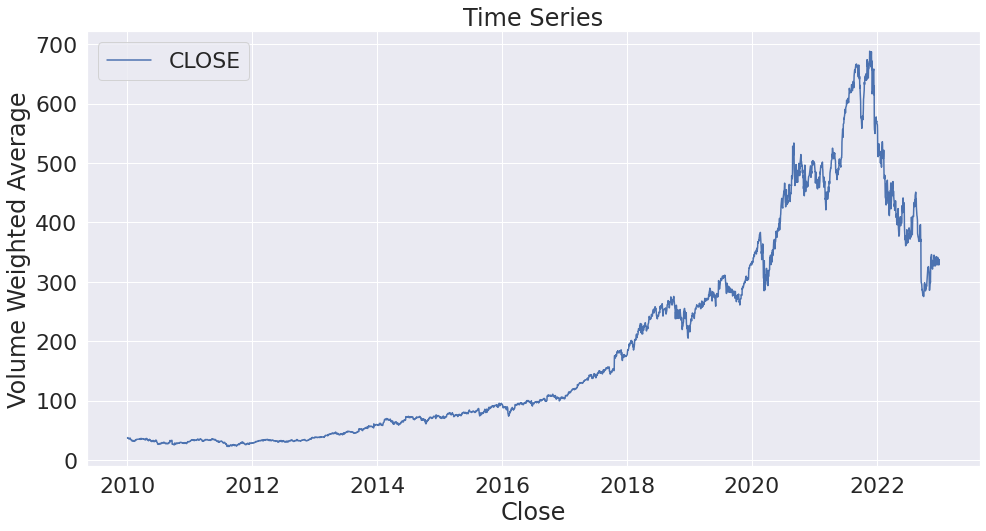

In [193]:
plt.figure(figsize=(10,8))

#  subplot #3
plt.figure(figsize=(16,8)) 
plt.plot(df['Close'], label='CLOSE') 
plt.title('Time Series') 
plt.xlabel("Close") 
plt.ylabel("Volume Weighted Average") 
plt.legend(loc='best')
      
plt.show()  # plot subplots


<Figure size 720x576 with 0 Axes>

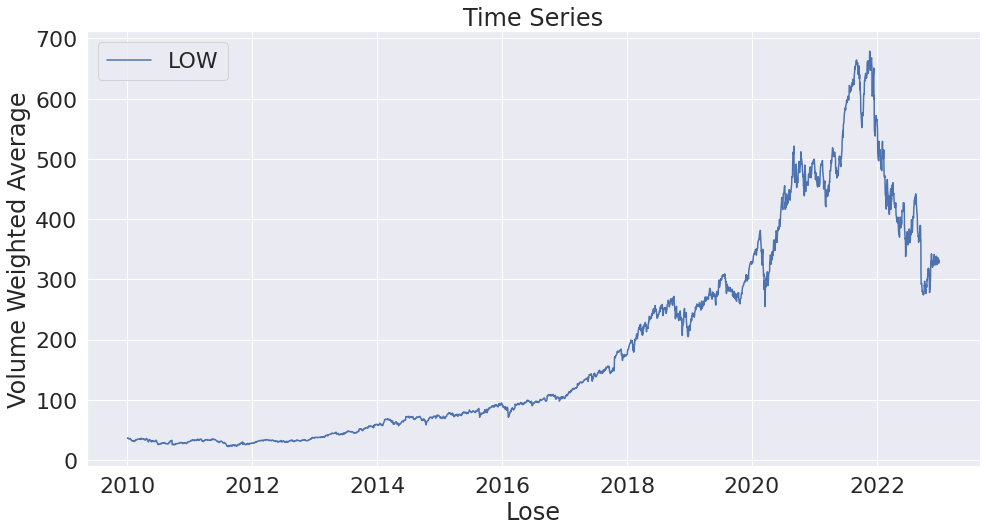

In [194]:
plt.figure(figsize=(10,8))

#  subplot #4
plt.figure(figsize=(16,8)) 
plt.plot(df['Low'], label='LOW') 
plt.title('Time Series') 
plt.xlabel("Lose") 
plt.ylabel("Volume Weighted Average") 
plt.legend(loc='best')
      
plt.show()  # plot subplots


<Figure size 720x576 with 0 Axes>

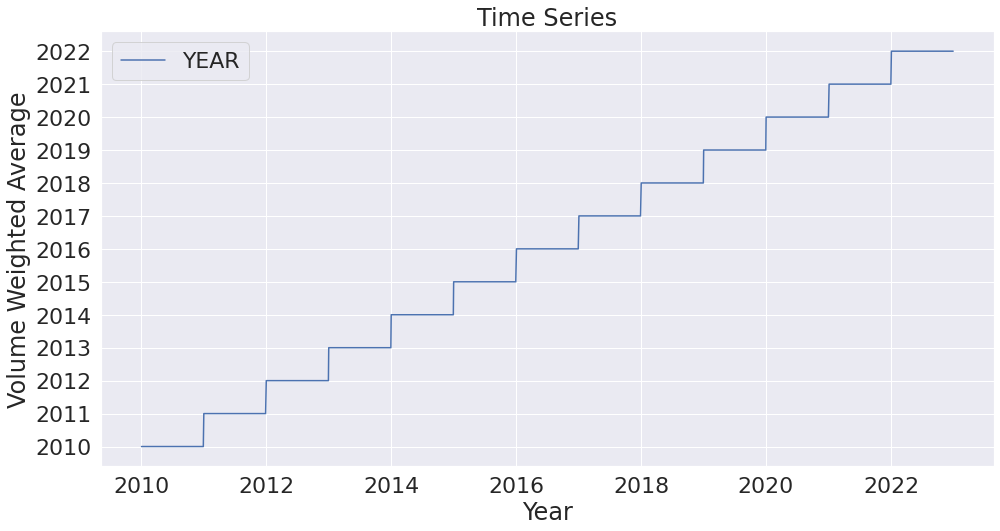

In [196]:
plt.figure(figsize=(10,8))

plt.figure(figsize=(16,8)) 
plt.plot(df['YEAR'], label='YEAR') 
plt.title('Time Series') 
plt.xlabel("Year") 
plt.ylabel("Volume Weighted Average") 
plt.legend(loc='best')
      
plt.show() 

<Figure size 720x576 with 0 Axes>

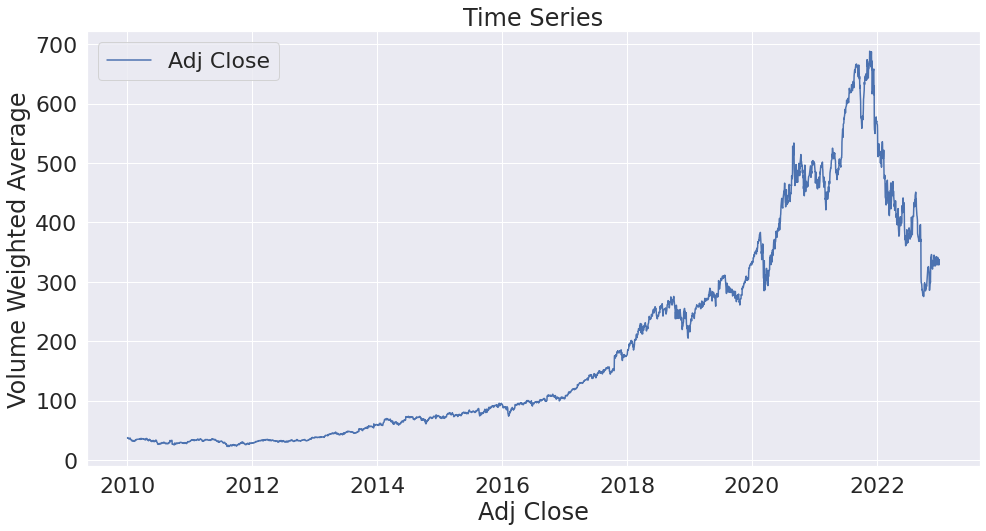

In [198]:
plt.figure(figsize=(10,8))

plt.figure(figsize=(16,8)) 
plt.plot(df['Adj Close'], label='Adj Close') 
plt.title('Time Series') 
plt.xlabel("Adj Close") 
plt.ylabel("Volume Weighted Average") 
plt.legend(loc='best')
      
plt.show()  # plot subplots


<AxesSubplot:xlabel='YEAR'>

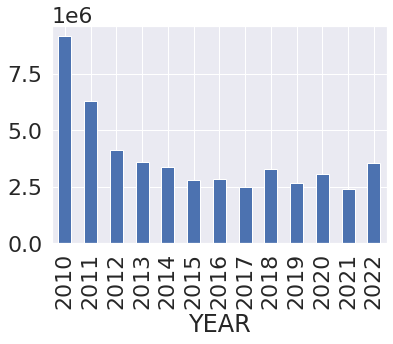

In [199]:
# Yearly Volume for Yahoo Finance Data (ADBE)

df.groupby('YEAR')['Volume'].mean().plot.bar()

<AxesSubplot:xlabel='YEAR'>

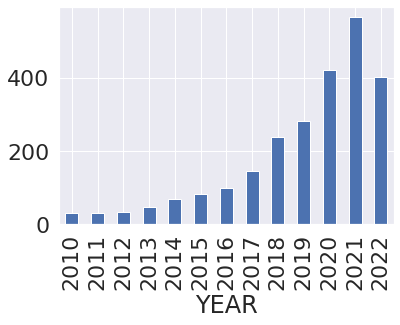

In [202]:
# Yearly High stock for Yahoo Finance Data (ADBE)

df.groupby('YEAR')['High'].mean().plot.bar()

Text(0.5, 1.0, 'Yearly Mean Volume for Yahoo Finance Data (ADBE)')

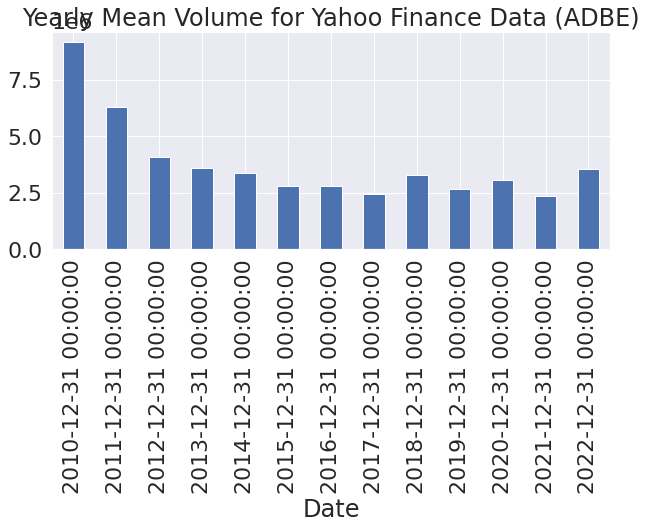

In [207]:
df['Volume'].resample('A').mean().plot(kind='bar',figsize = (10,4))
plt.title('Yearly Mean Volume for Yahoo Finance Data (ADBE)')

<AxesSubplot:xlabel='Date'>

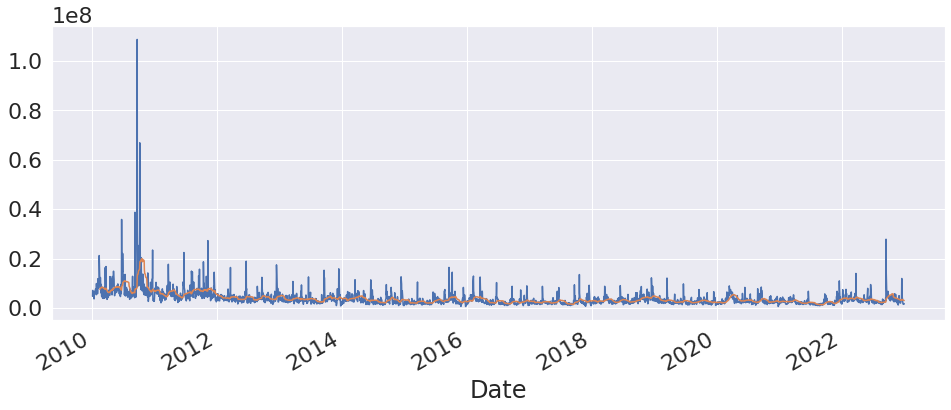

In [209]:
df['Volume'].plot()
df.rolling(window=30).mean()['Volume'].plot(figsize=(16, 6))

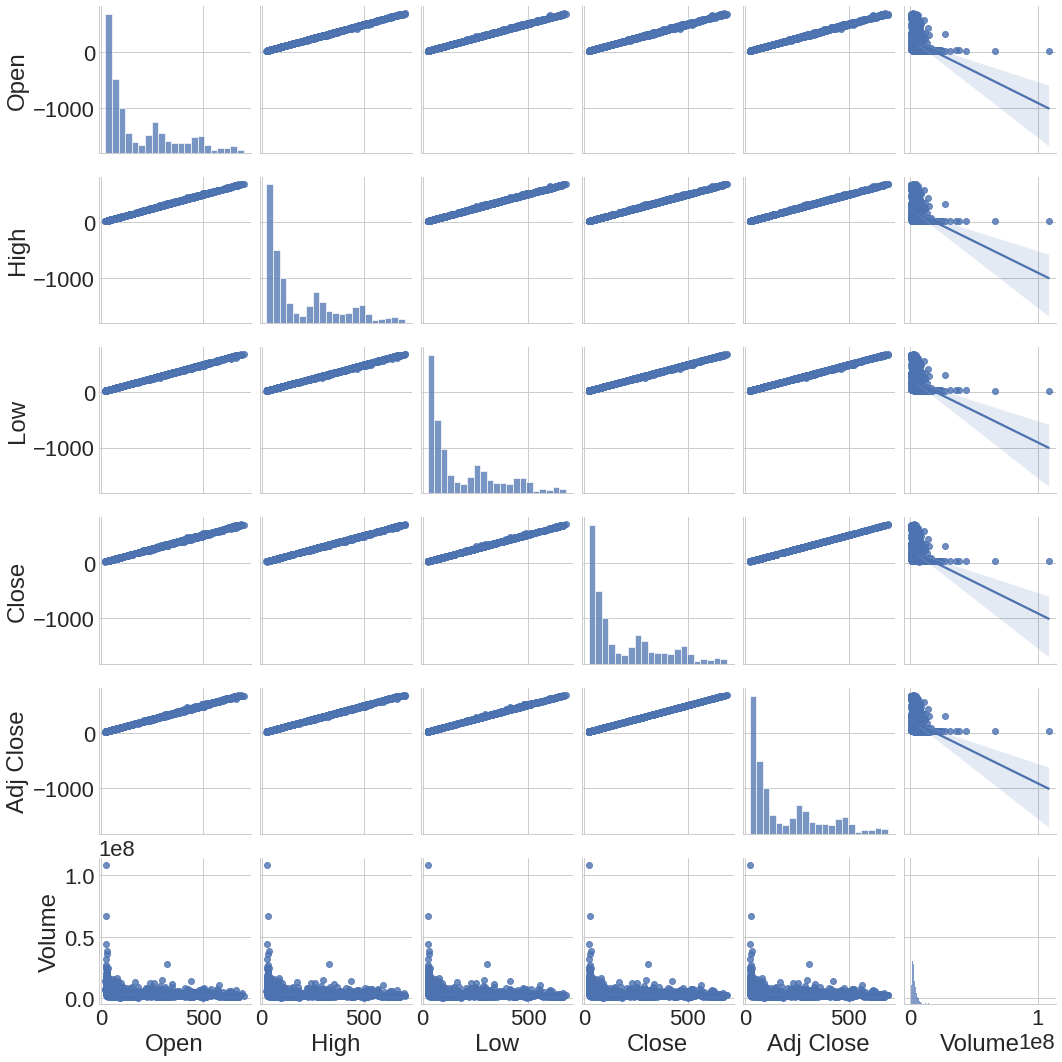

In [225]:
import seaborn as sns
sns.pairplot(df, kind='reg')

LinAlgError: ignored

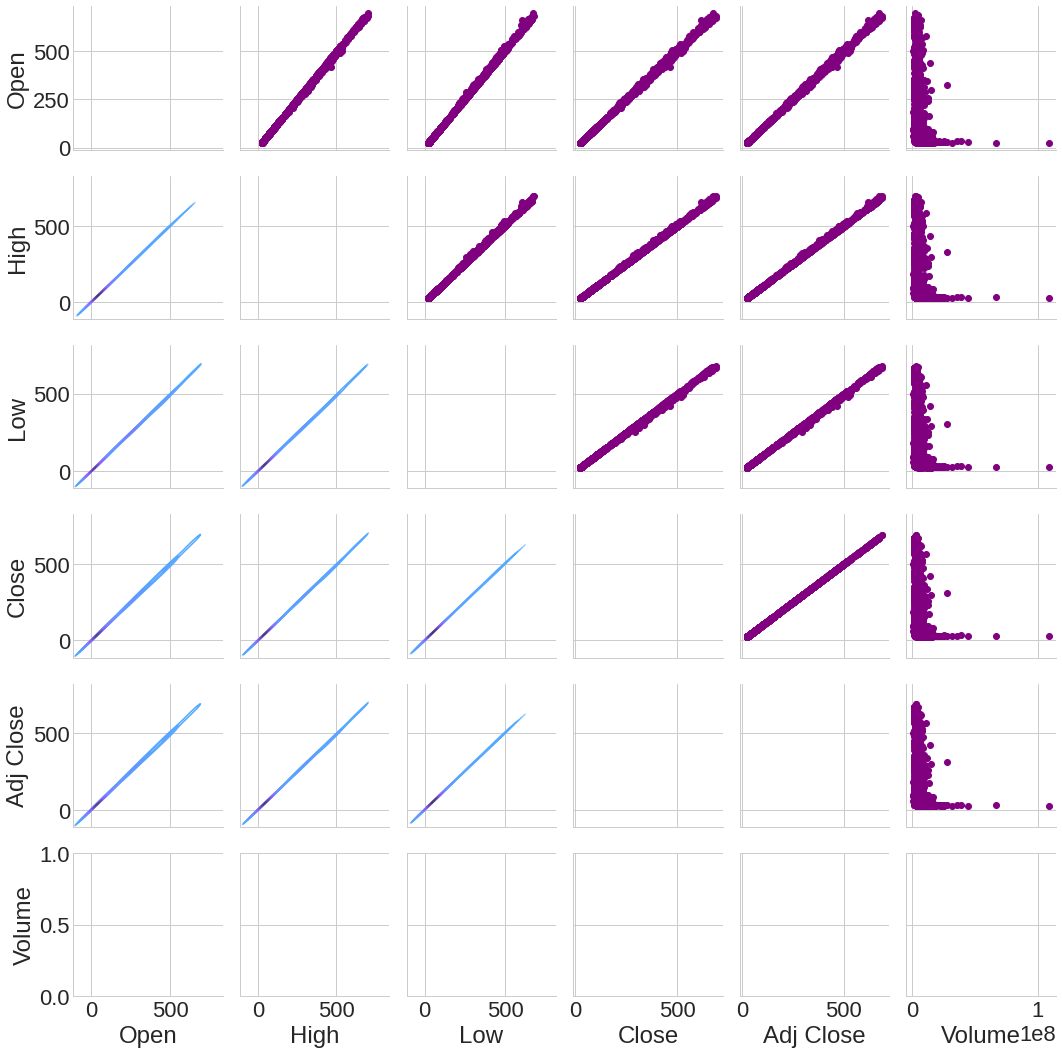

In [226]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(df.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

LinAlgError: ignored

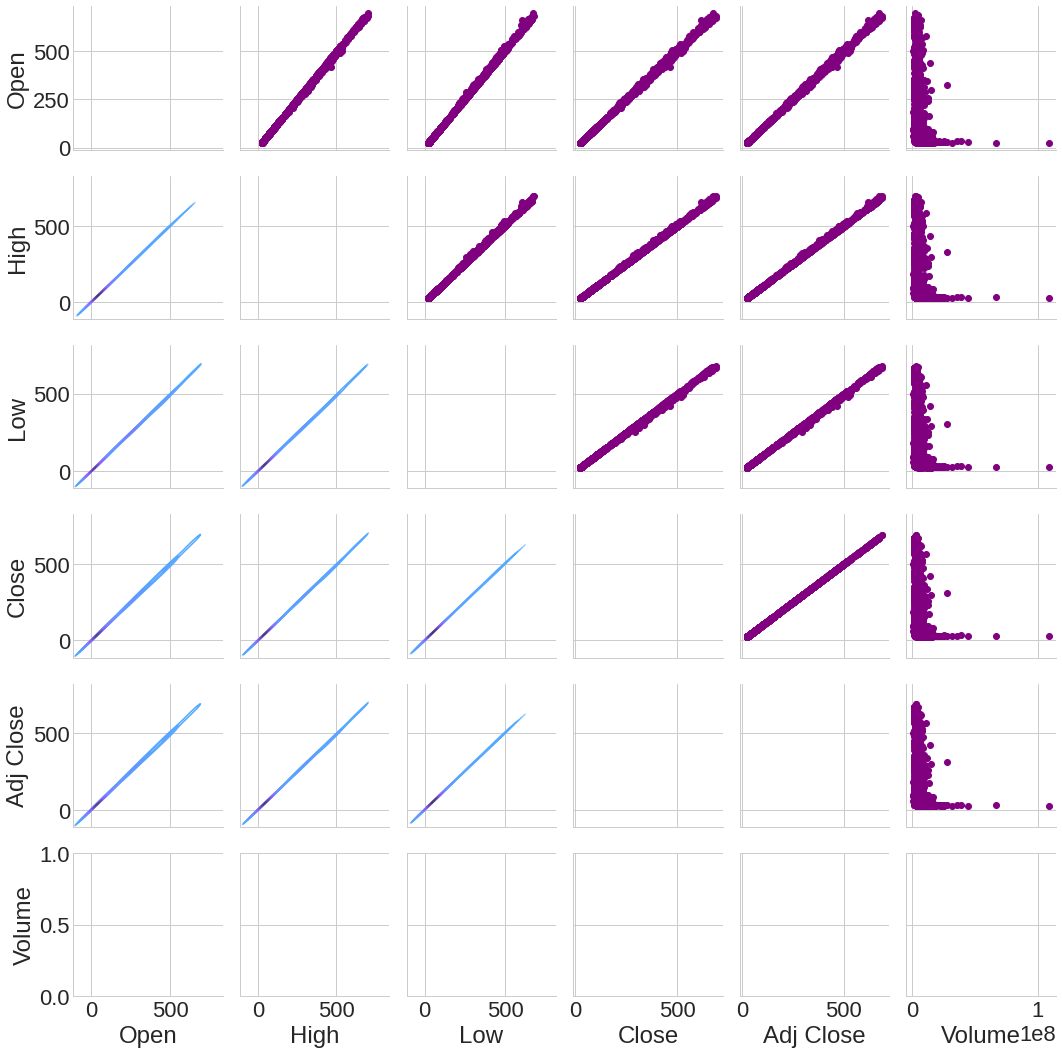

In [227]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

Text(0.5, 1.0, 'Correlation of stock closing price')

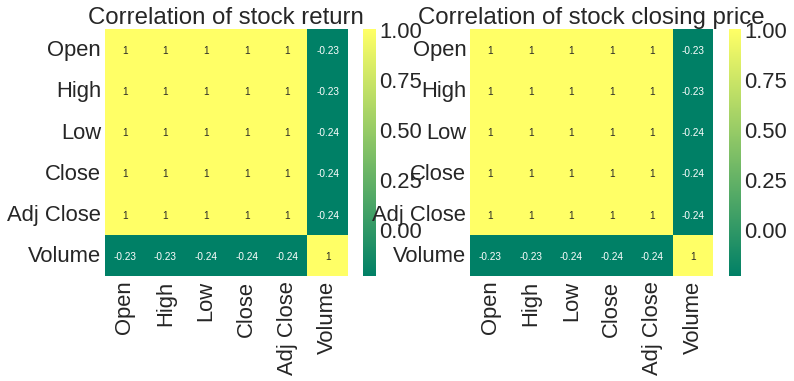

In [228]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')